Imports

In [11]:
import numpy as np
import cv2
import os
import glob

import matplotlib.pyplot as plt

from cv2 import aruco

from calibration_utils import *

Setting Source directory for camera calibration

In [12]:
data_path = '/home/eryk-dev/Desktop/100MSDCF/Callibration_Data/'

img_ext = "*.JPG"

img_shape = (4896, 3672)

Setting calibration values

In [13]:
board_shape = [7, 5]


# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


Preparing object points

In [14]:
dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_250)
parameters =  aruco.DetectorParameters()
arucoDetector = aruco.ArucoDetector(dictionary, parameters)


checker_size_m = 38 * 0.001
marker_size_m = 30 * 0.001


board = aruco.CharucoBoard(board_shape, checker_size_m, marker_size_m, dictionary)

Flag to display images while collecting data.

In [15]:
display_images = True

Processing Images

[1/15]
Chessboard detected DSC00203.JPG


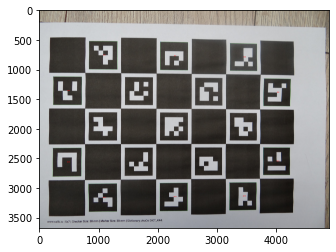

[2/15]
Chessboard detected DSC00204.JPG


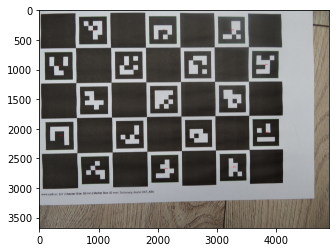

[3/15]
Chessboard detected DSC00205.JPG


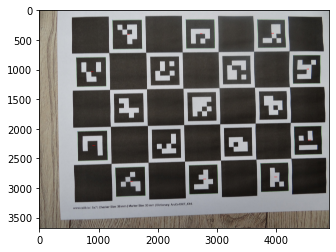

[4/15]
Chessboard detected DSC00206.JPG


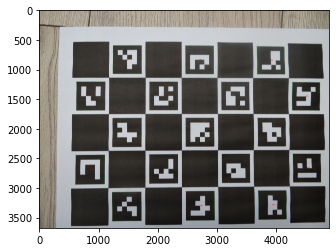

[5/15]
Chessboard detected DSC00207.JPG


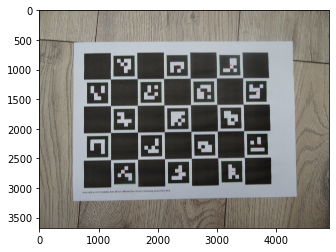

[6/15]
Chessboard detected DSC00209.JPG


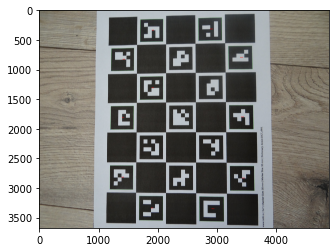

[7/15]
Chessboard detected DSC00211.JPG


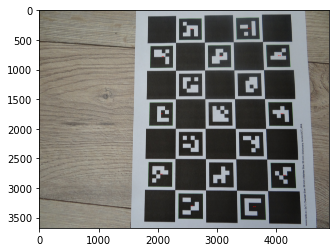

[8/15]
Chessboard detected DSC00212.JPG


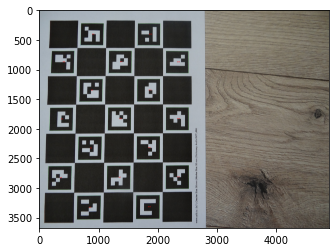

[9/15]
Chessboard detected DSC00213.JPG


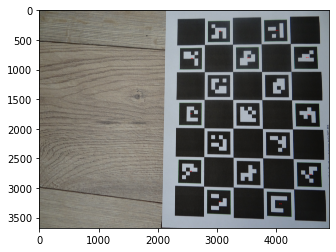

[10/15]
Chessboard detected DSC00214.JPG


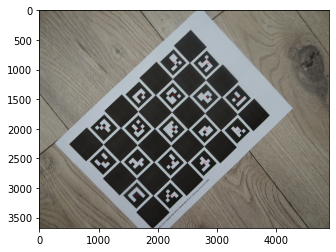

[11/15]
Chessboard detected DSC00215.JPG


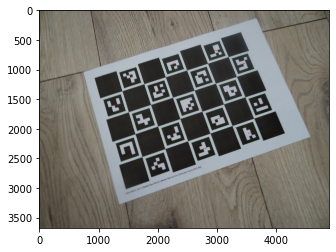

[12/15]
Chessboard detected DSC00216.JPG


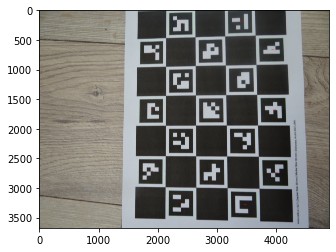

[13/15]
Chessboard detected DSC00217.JPG


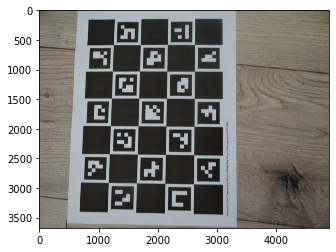

[14/15]
[15/15]
Chessboard detected DSC00219.JPG


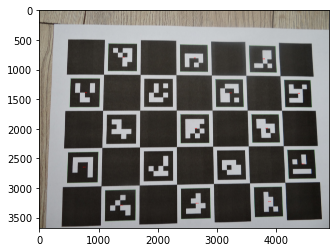


Detected 14 points


In [16]:

images = glob.glob(data_path + img_ext)
images.sort()

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

corner_ids = cornerIds(board_shape)

allCorners = []
allIds = []

for i, fname in enumerate(images):
    print("[" + str((i+1)) + "/" + str(len(images)) + "]")
    head, tail = os.path.split(fname)

    bgr = cv2.imread(images[i], cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    corners, ids, rejectedCorners = arucoDetector.detectMarkers(gray)

    if len(corners) > 4:
        for corner in corners:
            cv2.cornerSubPix(gray, corner,
                                winSize = (3,3),
                                zeroZone = (-1,-1),
                                criteria = criteria)
                    
        res2 = aruco.interpolateCornersCharuco(corners, ids, gray, board)

        if res2[1] is not None and max(ids) <= max(board.getIds()):
            if is_slice_in_list(numpy.squeeze(ids).tolist(), corner_ids): # all corners are detected
                params, board_rot_deg  = get_parameters(corners, numpy.squeeze(ids).tolist(), corner_ids, img_shape, board_shape)
                
                allCorners.append(res2[1])
                allIds.append(res2[2])
                    
                print('Chessboard detected ' + tail)

                if display_images :
                    # Draw and display the corners
                    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
                    
                    frame_copy = aruco.drawDetectedMarkers(rgb, corners, ids)
                    
                    plt.imshow(frame_copy)
                    plt.show()

        else:
            print("chessboards missing")

    else:
        print("chessboards missing")

print("\nDetected " + str(len(allCorners)) + " points")

Preparing for stereo calibration

In [17]:
print("CAMERA CALIBRATION")

cameraMatrixInit = np.array([[ 1000.,    0., img_shape[0] / 2.],
                            [    0., 1000.,  img_shape[1] / 2.],
                            [    0.,    0.,           1.]])

distCoeffsInit = np.zeros((5,1))

flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL)
#flags = (cv2.CALIB_RATIONAL_MODEL)

CAMERA CALIBRATION


Stereo calibration

In [18]:
print("Calculating ....")


(ret, camera_matrix, distortion_coefficients,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=img_shape,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 1000000, 1e-10))

print("Done")

Calculating ....
Done


Display Error

In [19]:
print("error: {}".format(ret))

error: 2.0103765003909


Printing results

In [20]:
print('Intrinsic_mtx', camera_matrix)
print('dist', distortion_coefficients)

Intrinsic_mtx [[1.01941440e+03 0.00000000e+00 2.40769664e+03]
 [0.00000000e+00 1.02271172e+03 2.10970448e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist [[ 7.71330061e-01]
 [-7.11316467e-01]
 [ 1.53800589e-03]
 [ 2.88477671e-04]
 [ 1.17125536e-01]
 [ 7.67921058e-01]
 [-7.09333246e-01]
 [ 1.16837179e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


Saving results

In [ ]:
np.savetxt('Intrinsic_mtx_1.txt', camera_matrix)
np.savetxt('dist_1.txt', distortion_coefficients)
#np.savetxt('rotation_vectors.txt', rotation_vectors)
#np.savetxt('translation_vectors.txt', translation_vectors)

In [ ]:
imgpoints, objpoints = calculateImgPointsObjPoints(allIds, allCorners, board)

In [ ]:
#Reprojection error
def computeReprojectionErrors(objectPoints, imagePoints, rvecs, tvecs, cameraMatrix, distCoeffs, perViewErrors):
    imagePoints2 = []
    totalPoints = 0
    totalErr = 0

    for i in range(len(objectPoints)):
        imagePoints2, _ = cv2.projectPoints(objectPoints[i], rvecs[i], tvecs[i], cameraMatrix, distCoeffs)

        err = np.linalg.norm(np.array(imagePoints[i]) - np.array(imagePoints2))
        n = len(objectPoints[i])
        perViewErrors.append(np.sqrt(err**2 / n))
        totalErr += err**2
        totalPoints += n

    return np.sqrt(totalErr / totalPoints)

perViewErrors = []


err = computeReprojectionErrors(objpoints, imgpoints, rotation_vectors, translation_vectors, camera_matrix, distortion_coefficients, perViewErrors)


for (frame, err) in zip(images, perViewErrors):
    print(os.path.basename(frame) + ' ' + str(err))
